In [2]:
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.1/678.1 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

## 1. **Decision Tree Regression**

we show how to create, train and evaluate a decision tree regression model using Concrete-ML library.



"In this context, we will use the following terms:

- **Plaintext:** Data that is unprotected and visible to anyone with access to it.
- **Ciphertext:** Encrypted data that requires knowledge of a secret key to decrypt.

Conventional models operate on plaintext data, while ConcreteML has the capability to directly process ciphertext. This preserves privacy because the model does not have access to the secret key and therefore cannot decrypt the data. Instead, it generates an encrypted estimate for the owner of the secret key."

In [1]:
import sys
import time

import numpy as np
import sklearn as sk
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import concrete.ml
from concrete.ml.sklearn import DecisionTreeRegressor as ConcreteDecisionTreeRegressor

print(f"Using ConcreteML version {concrete.ml.version.__version__}")
print(f"With Python version {sys.version}")

Using ConcreteML version 1.6.0
With Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


We will be using California housing prices dataset available in the scikit-learn package.

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


In [5]:
features_all, target_all = fetch_california_housing(return_X_y=True)
features, target = resample(features_all, target_all, replace=True, n_samples=6000, random_state=42)

# Split data in train-test groups
x_train, x_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.15,
    random_state=42,
)

We provide also a quick visualisation of our target variable

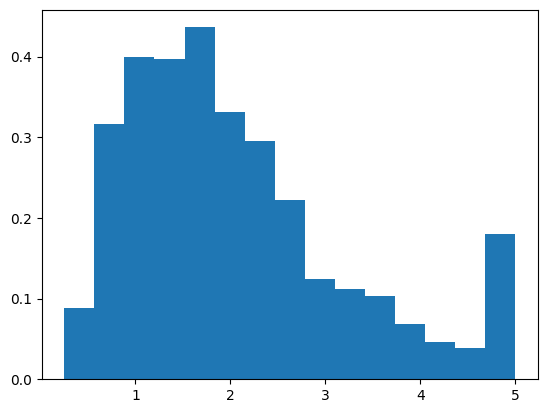

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(target, bins=15, density=True)
plt.show()

**Assessing Accuracy**

To gauge the accuracy of our models, we employ the mean absolute error (MAE), which retains the units of measurement—in this case, dollars.

To benchmark accuracy, we will compare our decision trees against a simpler model (a canary model). While using the median of the target could be considered overly simplistic, we opt for a univariate linear regression model as our canary. This choice is based on the expectation that income correlates somewhat proportionally with house value.

In [8]:
# Utility functions


def print_as_dollars(x):
    """Prints the value * 100'000$"""
    return f"{x * 10**5:.2f}$"


def print_compare_to_baseline(x, baseline_error):
    """Prints percentage improvement over baseline"""
    return f"{(x - baseline_error) / baseline_error * 100 :.2f}% of baseline"


mean_error = mean_absolute_error(y_test, np.repeat([np.median(y_test)], y_test.shape))
print(f"Mean Absolute Overall Error : {print_as_dollars(mean_error)}")

Mean Absolute Overall Error : 89922.83$


In [9]:
canary = LinearRegression()
canary.fit(x_train[:, :1], y_train)
baseline_error = mean_absolute_error(canary.predict(x_test[:, :1]), y_test)
print(f"Baseline Mean Error : {print_as_dollars(baseline_error)}")

Baseline Mean Error : 62719.65$


**Training a Decision Tree**

The ConcreteDecisionTreeRegressor in Concrete-ML corresponds to scikit-learn's DecisionTreeRegressor. It shares similar parameters and interface, with the added capability of making predictions directly on ciphertext without decryption, thereby preserving privacy.

Currently, Concrete-ML models require training on plaintext data. To demonstrate its functionality, we train a DecisionTreeRegressor with default parameters and evaluate its accuracy on test data. It's important to note that predictions are also made on plaintext data at this stage, but we will soon transition to making predictions on ciphertext.

In [10]:

default_model = ConcreteDecisionTreeRegressor(criterion="absolute_error", n_bits=6, random_state=42)

begin = time.time()
default_model.fit(x_train, y_train)
print(f"Training on {x_train.shape[0]} samples in {(time.time() - begin):.4f} seconds")

Training on 5100 samples in 41.1988 seconds


In [11]:

default_error = mean_absolute_error(default_model.predict(x_test), y_test)
print(
    f"Default Model Mean Error: {print_as_dollars(default_error)},"
    f"{print_compare_to_baseline(default_error, baseline_error)}"
)

Default Model Mean Error: 43788.10$,-30.18% of baseline


**Optimizing Hyperparameters**

Working with plaintext is significantly faster than working with ciphertext. We leverage this advantage to search for optimized hyperparameters for our dataset. Here, we employ a GridSearch strategy for simplicity, although other methods could be utilized as well.

In [12]:
# Find best hyper parameters with cross validation
from sklearn.model_selection import GridSearchCV

# List of hyper parameters to tune
param_grid = {
    "criterion": ["absolute_error"],
    "random_state": [42],
    "max_depth": [10],
    "n_bits": [6, 7],
    "max_features": [2, 5],
    "min_samples_leaf": [2, 5],
    "min_samples_split": [2, 10],
}

grid_search = GridSearchCV(
    ConcreteDecisionTreeRegressor(),
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    error_score="raise",
    n_jobs=1,
)

gs_results = grid_search.fit(x_train, y_train)
print("Best hyper parameters:", gs_results.best_params_)
print(f"Min lost: {print_as_dollars(-gs_results.best_score_)}")

Best hyper parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_bits': 7, 'random_state': 42}
Min lost: 43828.16$


**Quantization**

You may have noticed that we used a hyperparameter that does not have an equivalent in scikit-learn: `n_bits`. This is a unique aspect of homomorphic encryption: values must be converted into (relatively small) integers before encryption. This process is called quantization, and `n_bits` determines the maximum size of these quantized values. Simply put, a lower `n_bits` means less precise quantization, but faster FHE computations.

Whether our model benefits from increased precision and/or efficiency depends on finding the right balance. This balance is context-dependent. Currently, we observe that our model's performance improves with increased precision, indicated by higher `n_bits`.

In [13]:
# We fix all parameters as the best ones, except for n_bits.
best = gs_results.best_params_
cv_errors = [
    {"n_bits": params["n_bits"], "score": score}
    for params, score in zip(
        gs_results.cv_results_["params"], gs_results.cv_results_["mean_test_score"]
    )
    if (params["max_depth"] == best["max_depth"])
    and (params["max_features"] == best["max_features"])  # noqa: W503
    and (params["min_samples_leaf"] == best["min_samples_leaf"])  # noqa: W503
    and (params["min_samples_split"] == best["min_samples_split"])  # noqa: W503
]
for el in cv_errors:
    print(f"Error for n_bits={el['n_bits']} is {print_as_dollars(-el['score'])}")

Error for n_bits=6 is 45585.76$
Error for n_bits=7 is 43828.16$


**Training the Optimized Model**

Next, we train our model using the optimized hyperparameters. Initially, we set `n_bits` to a lower value to ensure reasonable computation time. Afterward, we explore the impact of higher `n_bits` values on computation time. Additionally, we utilize the `fit_benchmark` method instead of `fit` for convenient comparison with its scikit-learn counterpart.

In [14]:
# Build the model with best hyper parameters
model = ConcreteDecisionTreeRegressor(
    max_depth=gs_results.best_params_["max_depth"],
    max_features=gs_results.best_params_["max_features"],
    min_samples_leaf=gs_results.best_params_["min_samples_leaf"],
    min_samples_split=gs_results.best_params_["min_samples_split"],
    n_bits=6,
    random_state=42,
)

In [15]:
model, sklearn_model = model.fit_benchmark(x_train, y_train)

In [16]:
# Compute average precision on test
y_pred_concrete = model.predict(x_test)
y_pred_sklearn = sklearn_model.predict(x_test)
concrete_average_precision = mean_absolute_error(y_test, y_pred_concrete)
sklearn_average_precision = mean_absolute_error(y_test, y_pred_sklearn)
print(
    f"Sklearn  Mean Error: {print_as_dollars(sklearn_average_precision)},"
    f"{print_compare_to_baseline(sklearn_average_precision, baseline_error)}"
)
print(
    f"Concrete Mean Error: {print_as_dollars(concrete_average_precision)},"
    f"{print_compare_to_baseline(concrete_average_precision, baseline_error)}"
)


Sklearn  Mean Error: 45960.28$,-26.72% of baseline
Concrete Mean Error: 46691.16$,-25.56% of baseline


**Comparing Model Performance**

The Concrete model demonstrates performance similar to the scikit-learn model. However, differences may arise due to Concrete models employing potentially lossy quantization of data. Generally, we anticipate slightly lower accuracy for Concrete models, although this isn't always the case since models themselves are approximations.

**Predicting on Ciphertext**

While predictions may exhibit slight accuracy differences, the true advantage of ConcreteML lies in privacy. Here, we demonstrate how predictions can be made on ciphertext with Concrete-ML, ensuring the model does not need to decrypt data at all to compute estimates.

**Setup**

To enable our model to operate directly on ciphertext, we must:

- Compile the model into a circuit: This circuit represents our model's prediction program using FHE operations.
- Generate an encryption key specific to our circuit.

When deploying the model in a client-server architecture, the server handles model compilation and serving. Meanwhile, the client generates and safeguards the encryption key. The client encrypts data using its secret key before sending it to the server.

Note that during circuit compilation, the compiler requires data examples. Here, we use all our training data as samples, which increases compilation time but enhances security.

In [17]:

x_train_subset = x_train[:500]

begin = time.time()
circuit = model.compile(x_train_subset)
print(f"Compiled with {len(x_train_subset)} samples in {(time.time() - begin):.4f} seconds")

Compiled with 500 samples in 2.1574 seconds


In [18]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Generating a key for an 8-bit circuit
Key generation time: 3.00 seconds


**Predictions**

You can perform predictions directly on ciphertext by specifying the `fhe="execute"` argument in the `predict` method. However, it's important to note that computations on ciphertext are slower compared to plaintext.

In [19]:
FHE_SAMPLES = 3
x_test_small = x_test[:FHE_SAMPLES]
y_pred = y_test[:FHE_SAMPLES]


Previously, we obtained predictions using plaintext. Now, we demonstrate that the estimates from plaintext and ciphertext in our setup are identical. Typically, they may exhibit slight differences due to the introduction of noise in ciphertext.

In [20]:
# Predict in FHE for a few examples
time_begin = time.time()
y_pred_fhe = model.predict(x_test_small, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / FHE_SAMPLES:.2f} seconds per sample")

Execution time: 101.98 seconds per sample


In [21]:
# Check prediction FHE vs sklearn
print("Cipher estimates:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in y_pred_fhe)}")
print("Plain estimates:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in y_pred)}")
print("Differences:")
print(f"{', '.join(f'{print_as_dollars(x)}' for x in (y_pred_fhe - y_pred))}")

Cipher estimates:
293651.38$, 277778.33$, 126984.38$
Plain estimates:
290800.00$, 214600.00$, 102800.00$
Differences:
2851.38$, 63178.33$, 24184.38$


**Evaluation of Computation Times**

we assess both accuracy and computation times while incrementing the `n_bits` parameters.

In [22]:
# Concatenate all the steps in one function of n_bits


def evaluate(n_bits):
    model = ConcreteDecisionTreeRegressor(
        max_depth=gs_results.best_params_["max_depth"],
        max_features=gs_results.best_params_["max_features"],
        min_samples_leaf=gs_results.best_params_["min_samples_leaf"],
        min_samples_split=gs_results.best_params_["min_samples_split"],
        n_bits=n_bits,
        random_state=42,
    )

    model, sklearn_model = model.fit_benchmark(x_train, y_train)

    y_pred_concrete = model.predict(x_test)
    y_pred_sklearn = sklearn_model.predict(x_test)

    concrete_average_precision = mean_absolute_error(y_test, y_pred_concrete)
    sklearn_average_precision = mean_absolute_error(y_test, y_pred_sklearn)

    print(
        f"Sklearn  Mean Error: {print_as_dollars(sklearn_average_precision)},"
        f"{print_compare_to_baseline(sklearn_average_precision, baseline_error)}"
    )
    print(
        f"Concrete Mean Error: {print_as_dollars(concrete_average_precision)},"
        f"{print_compare_to_baseline(concrete_average_precision, baseline_error)}"
    )

    x_train_subset = x_train[:500]
    begin = time.time()
    circuit = model.compile(x_train_subset)
    print(
        f"Circuit compiled with {len(x_train_subset)} samples in {(time.time() - begin):.4f} "
        "seconds"
    )
    print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")

    time_begin = time.time()
    circuit.client.keygen(force=False)
    print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

    time_begin = time.time()
    model.predict(x_test_small, fhe="execute")
    print(f"Execution time: {(time.time() - time_begin) / FHE_SAMPLES:.2f} seconds per sample")


for n_bits in [6, 7]:
    header = f"N_BITS = {n_bits}"
    print(header)
    print("-" * len(header))
    evaluate(n_bits)
    print()

N_BITS = 6
----------
Sklearn  Mean Error: 45960.28$,-26.72% of baseline
Concrete Mean Error: 46691.16$,-25.56% of baseline
Circuit compiled with 500 samples in 1.9625 seconds
Generating a key for an 8-bit circuit
Key generation time: 2.97 seconds
Execution time: 114.43 seconds per sample

N_BITS = 7
----------
Sklearn  Mean Error: 45960.28$,-26.72% of baseline
Concrete Mean Error: 43046.38$,-31.37% of baseline
Circuit compiled with 500 samples in 2.6071 seconds
Generating a key for an 9-bit circuit
Key generation time: 2.97 seconds
Execution time: 116.61 seconds per sample



**Impact of Increasing n_bits**

As observed, increasing the `n_bits` parameter can significantly escalate computation times to a prohibitive extent. However, enhanced quantization precision does not inherently reduce the model's generalization error, considering that predictions are already approximations in nature.

**Conclusion**

Implementing a decision tree regressor in Concrete-ML closely mirrors its usage in scikit-learn

**2. Support Vector Machine(SVM)**

we show how to create, train, and evaluate a Support Vector Machine (SVM) model
using Concrete-ML library for a classification task.

In [37]:
# Support Vector Machine

# display visualizations and plots in the notebook itself
%matplotlib inline

# import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC as SklearnLinearSVC

# import the concrete-ml LinearSVC implementation
from concrete.ml.sklearn.svm import LinearSVC as ConcreteLinearSVC

The following code defines a visualization function that plots the decision boundary over the 2 principal components.

In [38]:
def plot_decision_boundary(
    clf,
    X,
    y,
    title="LinearSVC Decision Boundary",
    xlabel="First Principal Component",
    ylabel="Second Principal Component",
):
    # Perform PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create the mesh grid
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Transform the mesh grid points back to the original feature space
    mesh_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])

    # Make predictions using the classifier
    Z = clf.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors="k", marker="o", s=50)

    # Calculate the accuracy
    accuracy = accuracy_score(y, clf.predict(X))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (Accuracy: {accuracy:.4f})")
    plt.show()

Import and preprocess the dataset and make some adjustments to it.

In [39]:
# Get the data
df = pd.read_csv(
    "https://gist.githubusercontent.com/robinstraub/72f1cb27829dba85f49f68210979f561/"
    "raw/b9982ae654967028f6f4010bd235d850d38fe25b/pulsar-star-dataset.csv"
)
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [40]:
# Extract the features and labels
X = df.drop(columns=["target_class"])
y = df["target_class"]

# Replace N/A values with the mean of the respective feature
X.fillna(X.mean(), inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the floating labels to integer labels for both train and test sets
y_train = y_train.astype(int)
y_test = y_test.astype(int)

**Part 1: Train a simple model with Concrete-ML**

The following code quickly scaffolds a Concrete-ML LinearSVC code, which should sound familiar.

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

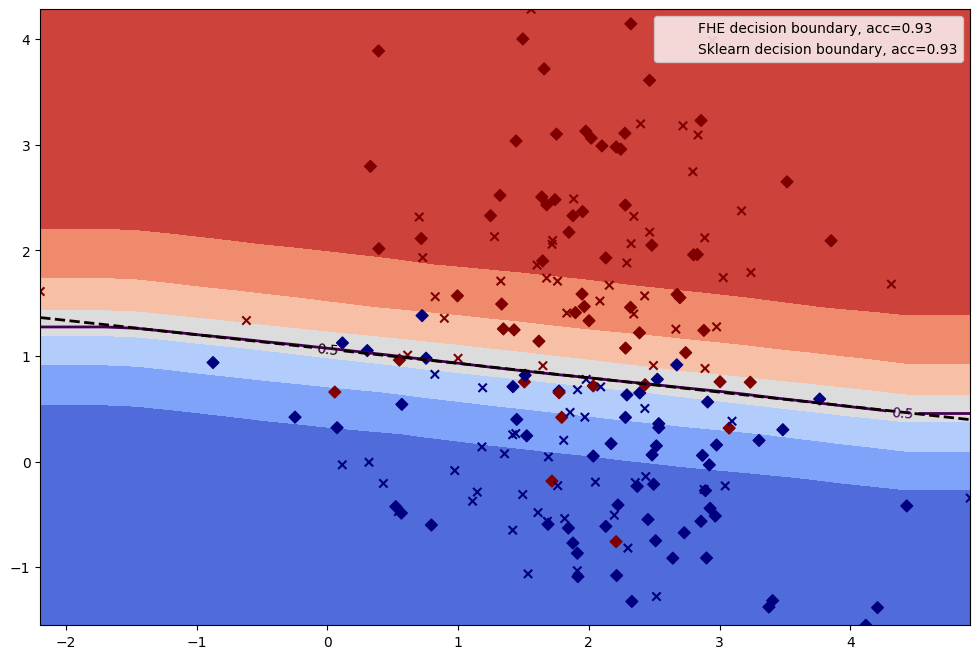

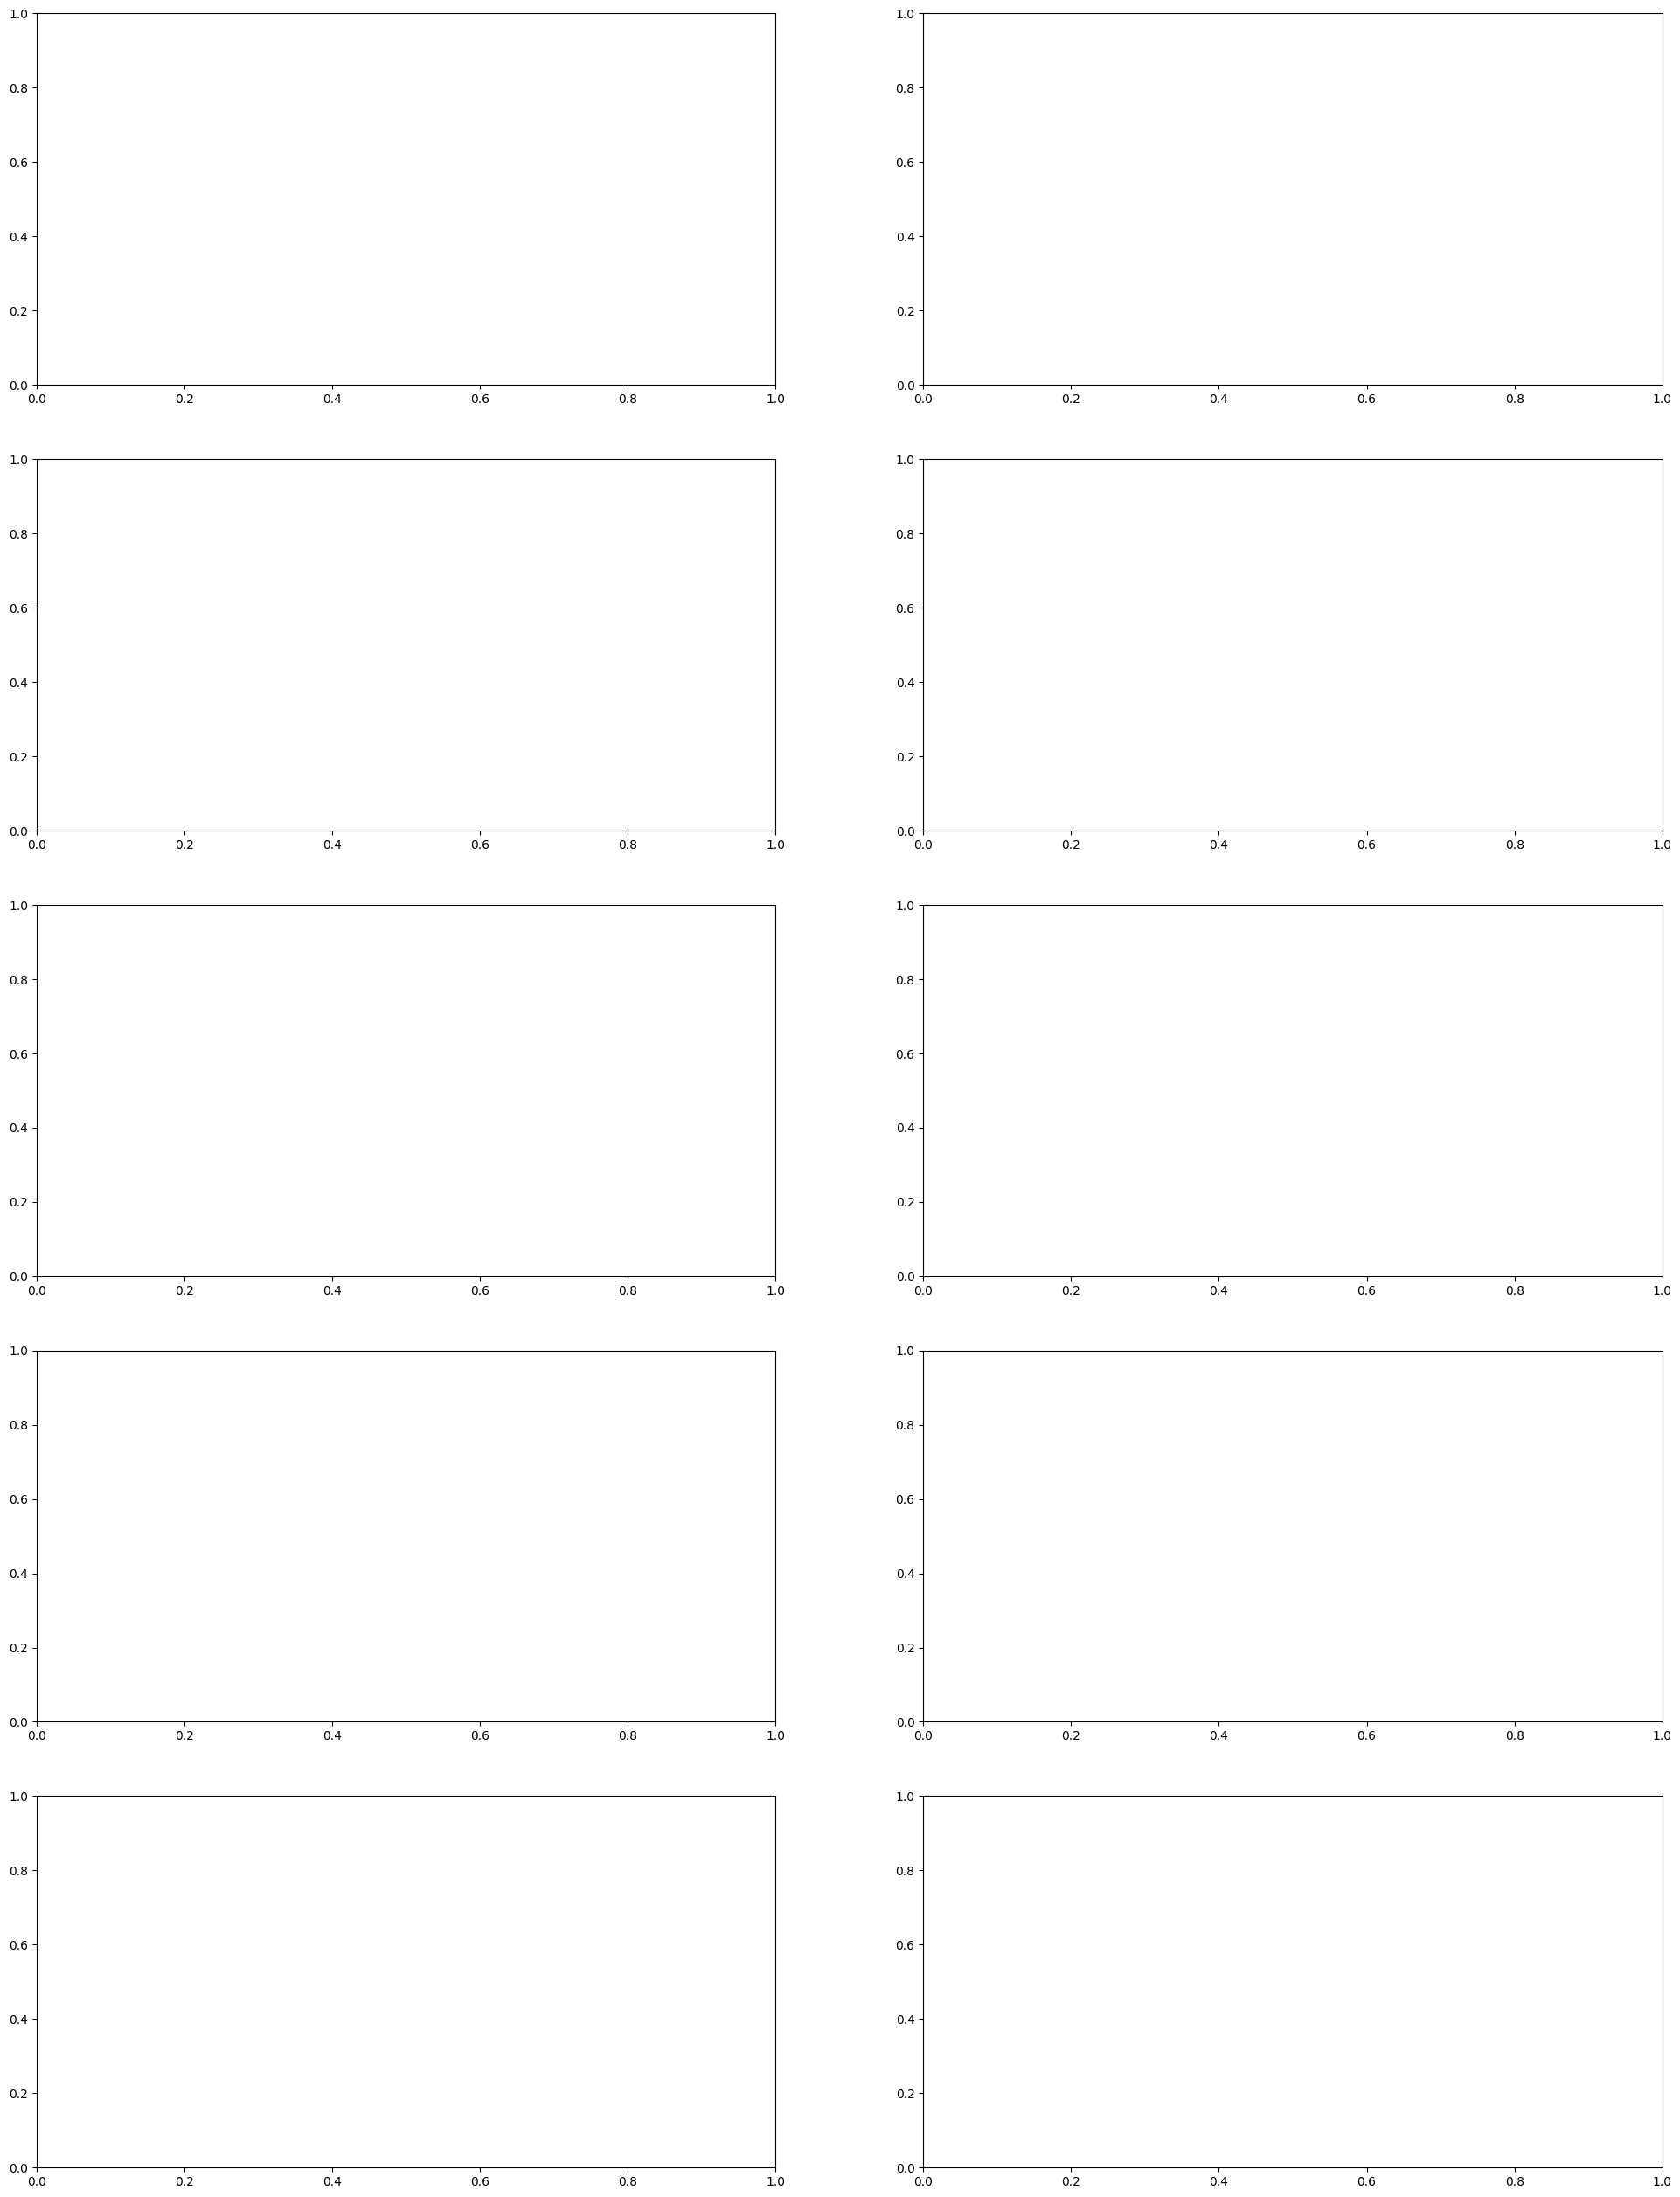

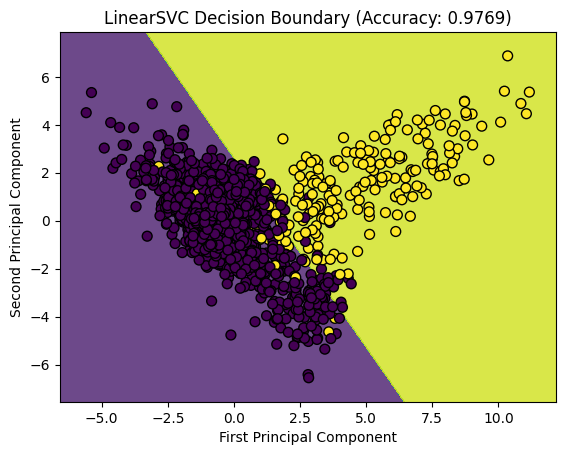

In [41]:
# Train a model with scikit-learn LinearSVC, perform prediction and compute the accuracy
svm_sklearn = SklearnLinearSVC(max_iter=100)
svm_sklearn.fit(X_train, y_train)
# plot the boundary
plot_decision_boundary(svm_sklearn, X_test, y_test)

Hopefully, this won't cause confusion. If it does, you might want to consult the official scikit-learn SVM documentation. The algorithm can be adjusted using the parameters available in the LinearSVC class.

While only the 2 main components of the dataset are plotted here, it's important to note that the dataset actually contains 8 features, so this is a simplified representation.

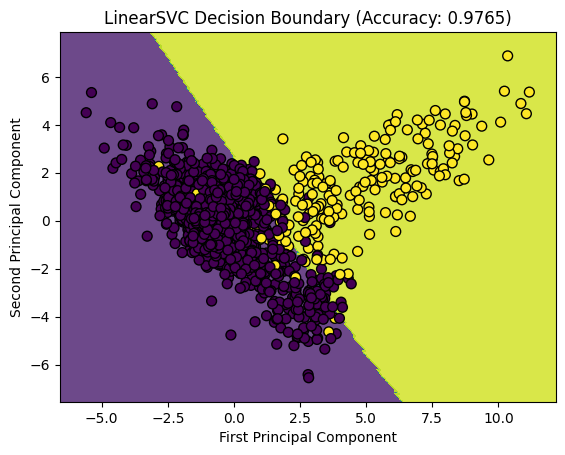

In [42]:

# Perform the same steps with the Concrete-ML LinearSVC implementation
svm_concrete = ConcreteLinearSVC(max_iter=100, n_bits=8)
svm_concrete.fit(X_train, y_train)
# plot the boundary
plot_decision_boundary(svm_concrete, X_test, y_test)

The decision boundary is no longer a straight line and appears "noisy" due to the quantization of the data. Despite this, the prediction remains accurate. In this example, the prediction matches the scikit-learn implementation. However, reducing the bit size can lead to a drop in accuracy, as quantization reduces data precision.

It's important to note that the model is trained on clear data, and predictions are also made in a plaintext environment, with no encryption at this stage.

To perform predictions in an FHE environment, the model must first be compiled into a circuit.

In [43]:
# A circuit needs to be compiled to enable FHE execution
circuit = svm_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred = svm_concrete.predict(X_test, fhe="execute")
accuracy = accuracy_score(y_test, y_pred)
# print the accuracy
print(f"FHE Accuracy: {accuracy:.4f} (bit width: {circuit.graph.maximum_integer_bit_width()})")

FHE Accuracy: 0.9765 (bit width: 17)


Now that the model is compiled, computing predictions with FHE is just a matter of passing a fhe parameter to execute.

Note that the accuracy of the predictions over FHE are the same as over plain (quantized) data -- FHE execution does not alter the model accuracy.



**Key Takeaways**

**Ease of Execution**
Concrete-ML offers a user-friendly interface similar to scikit-learn for high-level use cases. The primary distinction is that a model must be compiled to enable execution in FHE.

**Model Accuracy**
Prediction accuracy in Concrete-ML may slightly lag behind that of a typical scikit-learn implementation. This is due to quantization, where number precision must be fixed for evaluation in FHE. However, this difference can often be minimized to the point of being negligible (as seen here with an 8-bit size).

**Execution Time**
Execution speed in Concrete-ML can be slower, particularly during compilation and FHE inference phases, because FHE operations require more resources than regular inference on plaintext data. However, speed can be enhanced by reducing the precision of data and model weights using the `n_bits` parameter. Nevertheless, depending on the project, there exists a trade-off between a slower yet more accurate model and a faster but less accurate one.

**Part 2: Comprehensive Model Development**

This section delves deeper into the development process with Concrete-ML, demonstrating effective strategies for model refinement.

In particular:

- Exploring the impact of quantization and determining optimal bit precision.
- Configuring FHE simulation to streamline the development workflow.
- Implementing inference to apply the model with encrypted data.

**Step a: Training the Model**

There are no surprises here; a robust model must be trained to address this machine-learning challenge. We can simply build upon our previous work.

In [44]:
# setup and train a scikit-learn LinearSVC model, just as before
svm_sklearn = SklearnLinearSVC()
svm_sklearn.fit(X_train, y_train)
# predict some test data and measure the model accuracy
y_pred_sklearn = svm_sklearn.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Scikit-learn Accuracy: {accuracy_sklearn:.4f}")

Scikit-learn Accuracy: 0.9769


"Not bad.

**Step b: Quantizing the Model**

Up to this point, we've conveniently avoided most of the specifics related to Concrete-ML for the sake of simplicity. The first Concrete-ML specific step in developing a model is quantization, which essentially means converting the model into an integer equivalent.

While it's highly recommended to read the Zama introduction to quantization for a deeper understanding, the main takeaway is that quantization reduces the model to a discrete, smaller format necessary for encryption. Otherwise, the data becomes too large to handle in FHE.

As of version 1.0, the maximum bit size is 16. A lighter bit size enhances the efficiency of the Concrete-ML model. Therefore, the objective of the quantization step is to determine the lowest bit size that maintains acceptable accuracy, thereby maximizing model efficiency.

We observe that accuracy generally increases with bit size, though it remains quite good even at lower bit sizes.

Let's proceed with a more systematic approach to selecting the optimal `n_bit` parameter, along with some common parameters for LinearSVC."

In [45]:
svm = ConcreteLinearSVC()

# Define the parameter grid for the grid search
param_grid = param_grid = [
    {
        "C": np.logspace(-3, 3, 7),
        "n_bits": range(2, 17),
        "penalty": ["l1", "l2"],
        "dual": [False, True],
    },
]

# Use the F1 score as the metric to optimize, as it provides a
# balanced trade-off between precision and recall
scorer = make_scorer(f1_score, average="weighted")

# Set up the grid search with the custom scoring function
grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Convert the grid search results into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Define a custom function to highlight a specific row based on n_bits value


def highlight_row(row, n_bits_value=3, color="green"):
    return [
        f"background-color: {color}" if row["param_n_bits"] == n_bits_value else "" for _ in row
    ]


# Find the best hyperparameter combination for each n_bits value
best_results = results_df.loc[results_df.groupby("param_n_bits")["mean_test_score"].idxmax()]
best_results = best_results[
    ["param_n_bits", "param_C", "param_penalty", "param_dual", "mean_test_score"]
]
best_results.reset_index(drop=True, inplace=True)

# Display the best results DataFrame
best_results.style.apply(highlight_row, n_bits_value=3, axis=1).hide()

param_n_bits,param_C,param_penalty,param_dual,mean_test_score
2,0.001000,l2,False,0.945603
3,1.000000,l1,False,0.971102
4,0.010000,l2,False,0.970423
5,10.000000,l1,False,0.973795
6,10.000000,l2,True,0.973555
7,10.000000,l2,True,0.973608
8,10.000000,l1,False,0.973025
9,100.000000,l2,True,0.974334
10,10.000000,l2,True,0.972848
11,1.000000,l1,False,0.972914


**Step c: Simulate Model Execution**

Executing models using FHE can be time-consuming, influenced by factors such as:

- The size of the dataset
- The complexity of the model
- The hardware used for model execution

Setting up a model in Concrete-ML involves additional steps compared to standard models. For example, users need to choose the quantization bit-width for both the model's weights and input data, which can be intricate and time-intensive during actual FHE inference. However, Concrete-ML offers an FHE simulation mode that allows users to optimize hyperparameters, finding the best balance between latency and performance.

In [46]:
svm_concrete = ConcreteLinearSVC(n_bits=3, C=1, dual=False, penalty="l1")
svm_concrete.fit(X_train, y_train)

# compile the model
circuit = svm_concrete.compile(X_train)

# the model can now be executed with FHE
y_pred = svm_concrete.predict(X_test, fhe="simulate")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with FHE simulation: {accuracy:.4f}")

Accuracy with FHE simulation: 0.9745


**Step d: Compile the Model**

Having chosen an appropriate bit size and parameters, we can now compile the model for FHE execution instead of relying on FHE simulation, enabling its deployment in production.

In [47]:
# predict the test set to verify the compiled model accuracy
y_pred = svm_concrete.predict(X_test, fhe="execute")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with FHE execution: {accuracy:.4f}")

Accuracy with FHE execution: 0.9745


**Conclusion**

Setting up FHE with Concrete-ML for a LinearSVC model is straightforward because Concrete-ML offers an implementation that mirrors the scikit-learn LinearSVC interface.

However, optimizing a model for FHE does require some additional steps. For LinearSVC models, the key focus is selecting an appropriate bit-size for quantizing the model. Additional tools can streamline the development process, such as reducing compilation times using FHE simulation.

Once the model is trained and quantized effectively, it's prepared for deployment and use in production.

### **3. Linear Regression**

A linear regression model is created using the Concrete ML library.

First, we generate a random clear dataset. We then compare two linear regression models:

- **sklearn_lr**: A model from Sklearn, trained, tested, and evaluated on clear data.
- **concrete_lr**: A model from Concrete ML, trained on clear data, then quantized and compiled in FHE, and finally tested on encrypted data.

This notebook aims to show how straightforward it is to use Concrete ML and how FHE secures data during the inference phase.

#### Import Libraries

We begin by importing the necessary packages.

In [48]:
# Linear Regression

import time

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

In [50]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(r2_score=None):
    label = "Scikit-Learn"
    if r2_score is not None:
        label += f", {'$R^2'}={r2_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}


def get_concrete_plot_config(r2_score=None):
    label = "Concrete ML"
    if r2_score is not None:
        label += f", {'$R^2'}={r2_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}

In [51]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

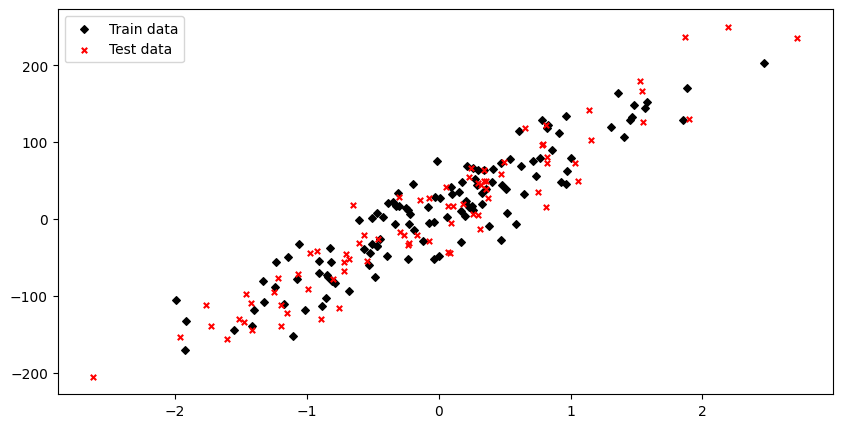

In [52]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

1. LinearRegression model from Sklearn

We train the scikit-learn LinearRegression model on clear data and then we test it.

In [53]:

sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)
y_pred = sklearn_lr.predict(X_test)

# Compute the R2 scores
sklearn_r2_score = r2_score(y_test, y_pred)

We can visualize our predictions to see how the scikit-learn model performs.

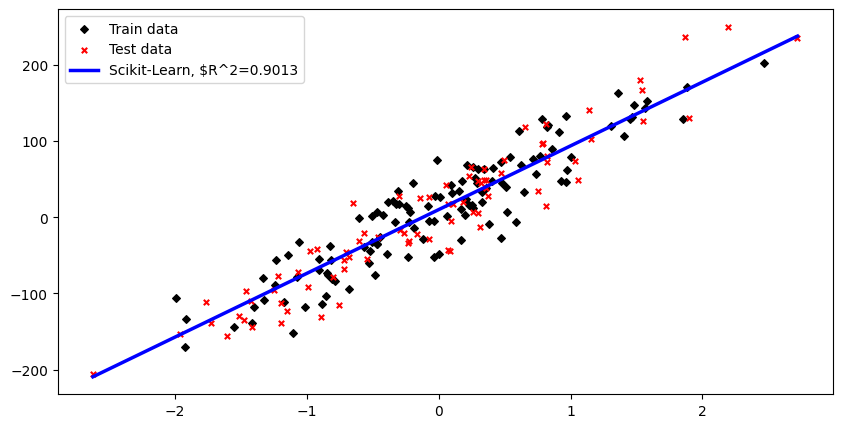

In [54]:
plt.ioff()
plt.clf()

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.legend()
display(fig)

### Prerequisites

Before diving in, there are some prerequisites to review!

**Quantization**: This technique converts continuous data (e.g., 32-bit floating points) to discrete numbers within a fixed range (e.g., 8-bit integers). This process involves some loss of information, but the error decreases as the range of integers increases, making it acceptable in certain cases.

**Fully Homomorphic Encryption (FHE)**: The input data type for FHE must be represented as integers, necessitating the use of quantization. Therefore, a linear model trained on floating-point numbers is quantized into an equivalent integer model using Post-Training Quantization. This operation can result in a slight loss of accuracy compared to standard floating-point models working on clear data.

However, in practice, this accuracy loss is minimal for linear FHE models, which can handle very large integers (up to 50 bits in some cases). These models can quantize their inputs and weights over a large number of bits (e.g., 16 bits) while still managing datasets with many features (e.g., 1000). Consequently, performance scores (e.g., R2 score) for float, quantized, and FHE models are often almost identical.

### 2. Linear Regression Model with Concrete ML

The typical development flow for a Concrete ML model is as follows:

1. **Training**: The model is trained on clear (plaintext) data, as only FHE inference is currently supported.

2. **Quantization**: The trained model is quantized using an `n_bits` parameter set by the user, which can be either:
   - A dictionary with `op_inputs` and `op_weights` keys. These parameters are integers representing the number of bits for quantizing the associated data.
   - A single integer representing the number of bits for quantizing each input and weight. The default is 8 bits.

3. **Compilation to FHE**: The quantized model is compiled into an FHE equivalent through three steps:
   - **Create an Executable Operation Graph**: Generate the operation graph for the model.
   - **Check FHE Compatibility**: Verify that the operation graph is FHE compatible by checking the maximum bit-width required to execute the model.
   - **Determine Cryptographic Parameters**: Identify cryptographic parameters to generate the secret and evaluation keys. If no suitable parameters are found, the compilation process cannot be completed, and an error is thrown. The user can then lower the `n_bits` value or reduce the number of features in the dataset (using techniques such as PCA) and run the development flow again.

4. **Inference**: Perform inference on encrypted data.





2.1 Quantized Linear Regression without FHE

In this example, we show you how to quantize a model with Concrete ML, and how to train and test it on plaintext data.

In [55]:
# We quantize the inputs using 8-bits
concrete_lr = ConcreteLinearRegression(n_bits=8)

# We train the concrete linear regression model on clear data
concrete_lr.fit(X_train, y_train)

# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_lr.predict(x_space)

# Now, we can test our Concrete ML model on the clear test data
y_pred_q = concrete_lr.predict(X_test)

# Compute the R2 scores
quantized_r2_score = r2_score(y_test, y_pred_q)

Now, let's visualize our predictions.

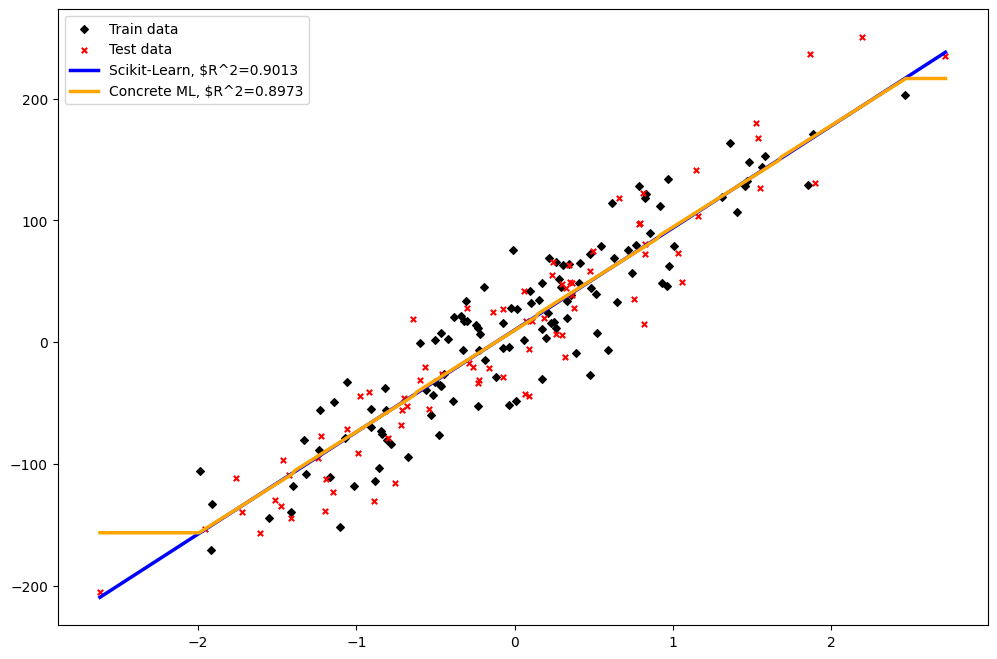

In [56]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(quantized_r2_score))
ax.legend()
display(fig)

As you can see, the quantized model almost perfectly matches its float equivalent model inside the training domain. There is however a very small decrease in the performance as the model poorly generalizes outside of it.

2.2 Quantized Linear Regression with FHE

To perform homomorphic inference, we take the above trained quantized model and we compile it to get an FHE model.

The compiler requires an exhaustive set of data to evaluate the maximum integer bit-width within the graph, which is needed during the FHE computations before running any predictions.

The user can either provide the entire train data-set or a smaller but representative subset of it.

In [57]:
fhe_circuit = concrete_lr.compile(X_train)

Generate the key
The compiler returns a circuit, which can then be used for key generation and predictions. More precisely, it generates:

a Secret Key, used for the encryption and decryption processes. This key should remain accessible only to the user.
an Evaluation Key, used to evaluate the circuit on encrypted data. Anyone could access this key without breaching the model's security.

In [58]:
print(f"Generating a key for a {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 9-bit circuit


Now that the model has been compiled, inference can be performed on encrypted data.

In [59]:
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0012 seconds


In [60]:
time_begin = time.time()
y_pred_fhe = concrete_lr.predict(X_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

Execution time: 0.0166 seconds per sample


Evaluate all the models

In the following, we use R^2-score metric to evaluate each model's performance.

In [61]:
# Measure the FHE R2 score
fhe_r2_score = r2_score(y_test, y_pred_fhe)

print("R^2 scores:")
print(f"scikit-learn (clear): {sklearn_r2_score:.4f}")
print(f"Concrete ML (quantized): {quantized_r2_score:.4f}")
print(f"Concrete ML (FHE): {fhe_r2_score:.4f}")

# Measure the error of the FHE quantized model with respect to the clear scikit-learn float model
concrete_score_difference = abs(fhe_r2_score - quantized_r2_score) * 100 / quantized_r2_score
print(
    "\nRelative score difference for Concrete ML (quantized clear) vs. Concrete ML (FHE):",
    f"{concrete_score_difference:.2f}%",
)

# Measure the error of the FHE quantized model with respect to the clear float model
score_difference = abs(fhe_r2_score - sklearn_r2_score) * 100 / sklearn_r2_score
print(
    "Relative score difference for scikit-learn (clear) vs. Concrete ML (FHE) scores:",
    f"{score_difference:.2f}%",
)

R^2 scores:
scikit-learn (clear): 0.9013
Concrete ML (quantized): 0.8973
Concrete ML (FHE): 0.8973

Relative score difference for Concrete ML (quantized clear) vs. Concrete ML (FHE): 0.00%
Relative score difference for scikit-learn (clear) vs. Concrete ML (FHE) scores: 0.45%


We can observe that scikit-learn and Concrete ML models output very close
 scores. This demonstrate how the quantization process has a very limited impact on performances.

**Plot the results of the Sklearn model and the FHE**

In [62]:
# For better visualization
y_pred_q_space = concrete_lr.predict(x_space)

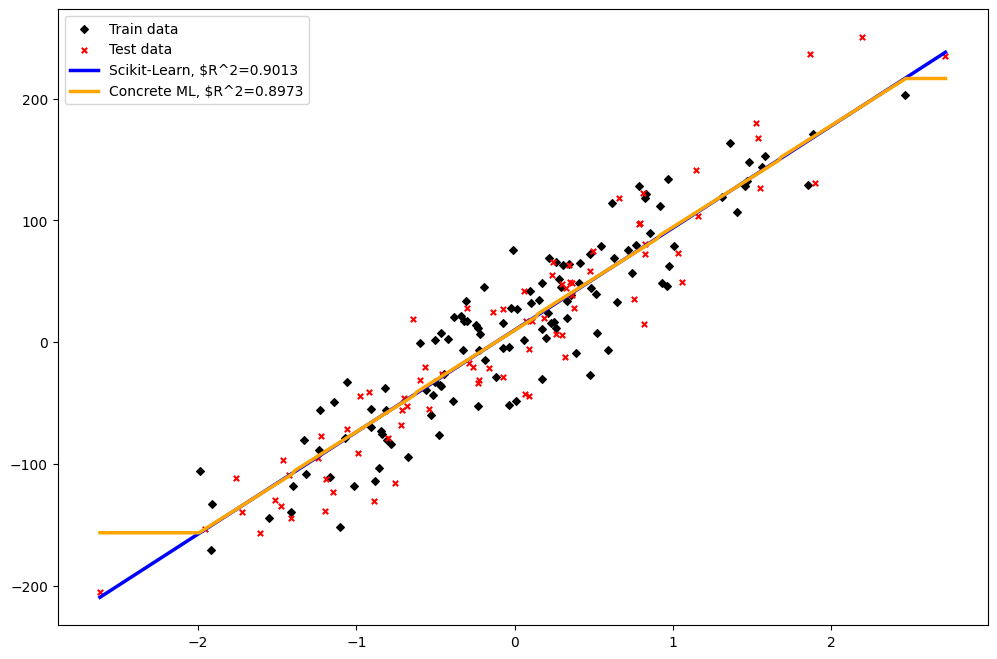

In [63]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(fhe_r2_score))
ax.legend()

display(fig)

### Conclusion

we demonstrated how straightforward it is to train and execute a linear regression model using Concrete ML in a fully homomorphic encryption (FHE) context.

We covered the development flow of an FHE model, including training, quantization, compilation, and inference.

The slight reduction in prediction quality is attributed to the quantization of the model's weights and input data, which can limit the model's ability to generalize beyond its training domain. However, this reduction is minimal, as both the floating-point (scikit-learn) and FHE (Concrete ML) models produce almost identical R2 scores.